In [1]:
%pip install numpy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


TABLE OF CONTENTS:

1) Prep Data for Emrax 188 Motors

2) Prep Data for AMK Motors

3) Prep Battery Data

Plot 1: Torque vs Irms

Purpose: To determine the flux linkage of the permanent magnet in the motor

In [2]:
import numpy as np

pairs = [(50, 30), (100, 53), (150,75), (200, 90)]

TI_array = np.array(pairs)

# Now fit a slope to this line
# Matrix for linear regression
G = np.array([np.ones(len(TI_array[:,0])), TI_array[:,0]])

G = np.transpose(G)

# y-values for linear regression
y = TI_array[:,1]

# Model output
coeffs = np.linalg.lstsq(G, y, rcond=None)[0]

# Determine PM flux linkage
pm = coeffs[1] / (3/2*10)
print(pm)

0.02693333333333333


Plot 2: Motor Torque vs Speed

Version 1 - Peak Torque

Version 2 - Continuous Torque

In [3]:
pairs_peak = [(0, 90), (1000, 90), (2000, 90), (3000, 90), (4000, 87), (5000, 85), (6000, 85), (7000, 80)]
pairs_cont = [(0, 45), (1000, 47), (2000, 52), (3000, 52), (4000, 52), (5000, 52), (6000, 50), (7000, 45)]

peak_arr = np.array(pairs_peak)
cont_arr = np.array(pairs_cont)

# initialize empty arrays - Fill each space with 100 points
peak = np.empty([0, 2])
cont = np.empty([0, 2])

# number of intermediate values
intermediateVals = 100

# Then fill the spaces in between using interpolation:
for i in range(0, len(pairs_peak) - 1):
    new_peak = np.linspace(peak_arr[i],peak_arr[i+1], intermediateVals)
    new_cont = np.linspace(cont_arr[i], cont_arr[i+1], intermediateVals)
    peak = np.append(peak, new_peak, axis=0)
    cont = np.append(cont, new_cont, axis=0)

# Now print the full outputs - thinking at the moment this may be a problem because the arrays have two columns
print(peak)

# The outputs are of the following form: [rpm, torque]

[[   0.           90.        ]
 [  10.1010101    90.        ]
 [  20.2020202    90.        ]
 ...
 [6979.7979798    80.1010101 ]
 [6989.8989899    80.05050505]
 [7000.           80.        ]]


Plot 3: Efficiency Curve

Process: converted online using https://plotdigitizer.com/app

Determined efficiencies and sent to a .csv file

Now: Unpack .csv and create lookup table for efficiencies

In [4]:
import pandas as pd

infile = "emrax_efficiency_data.csv"
eff_df = pd.read_csv(infile)
print(eff_df)

# Functions as lookup table

FileNotFoundError: [Errno 2] No such file or directory: 'emrax_efficiency_data.csv'

Output data for simulation - sent to json file

In [ ]:
import json

peak = peak.tolist()
cont = cont.tolist()
eff_df = eff_df.to_dict()

# Dictionary
outDict = {'lambda_pm': pm, 'PeakTorqueSpeed': peak, 'ContTorqueSpeed': cont,'Motor Efficiency': eff_df}

# Export as .json
outfile = "emrax_data.json"
with open(outfile, 'w') as export:
    export.write(json.dumps(outDict))

AMK Motor Data

Step 1: Torque-Speed Curve Data
* This is the MAXIMUM TORQUE per SPEED for both continuous and peak conditions

In [1]:
import pandas as pd

cols = ['Speed','Torque']

infile1 = "AMK_Peak_Torque_Speed.csv"
AMK_peak_df = pd.read_csv(infile1)

infile2 = "AMK_Cont_Torque_Speed.csv"
AMK_cont_df = pd.read_csv(infile2)

Step 2: Torque-Speed AND Current
* A more detailed plot from AMK for motor torque based on speed and current
* Conditions from AMK include: Current is varied from 0 to 105 A in steps of 5.25 A
* Motor rpm is varied from 0 to 20,000 rpm in steps of 100 rpm

So the concept here is:
* Initially, we start with peak torque (or continuous torque) - then we decrease the torque or speed or whatever based on current-limiting requirements

In [5]:
import numpy as np

infile = "AMK_ShaftTorque.csv"
step = 5.25
col_names = np.arange(0,105+step, step)

step = 100
row_names = np.arange(0,20000+step,step)

torque_matrix = pd.read_csv(infile, names=col_names)
torque_matrix = torque_matrix.dropna(axis=0)

torque_matrix.insert(0, "Speeds", row_names)
torque_matrix.set_index('Speeds', inplace = True)

1.317697268

In [10]:
# Now test using this as a lookup table
# We have two options:
# 1 - Use the extra two vectors to determine the location of the information in the lookup table
# 2 - Try to search through the header and the index

# my combined solution will be transfering only the dataframe to the final code and then using these vectors to search
colNames = list(torque_matrix.columns)
rowNames = list(torque_matrix.index)

# Function for finding a close match
def findClosestMatch(vector, x):
    # vector = vector # simplifying whatever form we were given as the vector

    index = np.searchsorted(vector, x)
    # based on the return value of searchsorted. We need to check THAT and the value below (with one edge case)
    if index != 0:

        if abs(x - vector[index]) > abs(x - vector[index - 1]):
            index = index - 1
    
    return index

current = 20    # A
torque = 4     # Nm
speed = 1200    # rpm

# Practice finding the RPM based on a KNOWN CURRENT and KNOWN TORQUE
current_index = findClosestMatch(colNames, current)
t_index = findClosestMatch(torque_matrix.iloc[:,current_index].to_list(), torque)
RPM_value = rowNames[t_index]     # return RPM value

# Practice finding TORQUE based on a KNOWN RPM and KNOWN CURRENT
current_index = findClosestMatch(colNames, current)
RPM_index = findClosestMatch(rowNames, speed)
Torque_value = torque_matrix.iloc[RPM_index, current_index]

# Practice finding current based on a KNOWN RPM and KNOWN TORQUE
RPM_index = findClosestMatch(rowNames, speed)
t_index = findClosestMatch(torque_matrix.iloc[RPM_index, :].to_list(), torque)
current_value = colNames[t_index]

Step 3: Power Factor Data AND total loss Data

In [11]:
# Total loss data
infile = "AMK_TotalLosses.csv"
loss_matrix = pd.read_csv(infile, names = col_names)
loss_matrix = loss_matrix.dropna(axis=0)

loss_matrix.insert(0, "Speeds", row_names)
loss_matrix.set_index('Speeds', inplace = True)

# Power Factor Data
infile = "AMK_PowerFactor.csv"
pf_matrix = pd.read_csv(infile, names = col_names)
pf_matrix = pf_matrix.dropna(axis=0)

pf_matrix.insert(0, "Speeds", row_names)
pf_matrix.set_index('Speeds', inplace = True)

# This could also be expanded to Temperature, etc.
# Add Voltage_Line_RMS
infile = "AMK_Voltage_Line_RMS.csv"
voltage_matrix = pd.read_csv(infile, names = col_names)
voltage_matrix = voltage_matrix.dropna(axis=0)

voltage_matrix.insert(0, "Speeds", row_names)
voltage_matrix.set_index("Speeds", inplace=True)

# Add Motor Power
infile = "AMK_Motor_Power.csv"
power_matrix = pd.read_csv(infile, names = col_names)
power_matrix = power_matrix.dropna(axis=0)

power_matrix.insert(0, "Speeds", row_names)
power_matrix.set_index("Speeds", inplace=True)

Export Data as JSON file

In [12]:
import json

torque_matrix = torque_matrix.to_dict()
pf_matrix = pf_matrix.to_dict()
loss_matrix = loss_matrix.to_dict()
voltage_matrix = voltage_matrix.to_dict()
power_matrix = power_matrix.to_dict()
AMK_peak_df = AMK_peak_df.to_dict()
AMK_cont_df = AMK_cont_df.to_dict()

# Combine data into a dictionary
outDict = {'ShaftTorque': torque_matrix, 'PowerFactor': pf_matrix, 'TotalLosses': loss_matrix, 'LineVoltageRMS': voltage_matrix, 'MotorPower': power_matrix, 'PeakTorqueSpeed': AMK_peak_df, "ContTorqueSpeed": AMK_cont_df}

# Export as .json
outfile = "AMK_data.json"
with open(outfile, 'w') as export:
    export.write(json.dumps(outDict))

In [13]:
import numpy as np

like = np.array([1, 2, 3])

a1 = np.array([1, 2, 3, 4, 5])
a2 = np.array([1, 2])
a3 = np.array([1, 2, 3, 4])

# atotal = np.empty_like(like)

# atotal[0] = a1
# atotal[1] = a2
# atotal[2] = a3

# ARRAY UNSUCCESSFUL

# Check dict
dtotal = dict({'a1': a1, 'a2': a2, 'a3': a3})
keylist = list(dtotal.keys())

# This will work and I will use the key list to iterate through the dict


# Can we put a dataframe into a dict?
# Import pandas library
import pandas as pd

# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Name', 'Age'])

dtotal['a1'] = df # answer is yes!

### P28A Battery SoC Curve Data
Using https://plotdigitizer.com/app again to generate a .csv file of the plots!

Some notes for myself:
1) This is given in "depth of discharge" - so the amount of capacity decrease. I could also just change the x-axis to make it the opposite... I think I'll do that.
2) To make it so that I don't have to make as many points on the curves - I will interpolate between the points when I make the calculations.
3) I will just jump to the closest curve (findClosestMatch) when choosing which to use

I accidentially recorded the curves in this order: red, blue, green

**Post Data Cleaning:**
1) The different C-rates will not have the same number of datapoints, so these will need to be in separate dictionaries or dataframes.
2) Capacity data must follow a downdward trend.
3) Capacity is in units of mAh.
4) Voltage is in units of V.
5) Will initially start with multiindexing to cleanly evaluate data. Then I will split them into their own categories.

#### Battery Charging Capacity vs Voltage Data
Curves given for voltage vs time AND capacity vs time.

Using interpolation and a constant time vector, create a vector which matches capacity values to voltage values at each point in time.

Curves are given for two voltages: 2.8 A and 5.6 A - so we'll just have to approximate to those. Label them as -2.8 and -5.6 and then we'll have to add them to the SoC lookup table -- and the SoC data from the section above.

Before interpolating, I had to make sure that the min x-value was 0 and the max x-value was 1.5 for both .csv files.

In [1]:
import pandas as pd
import numpy as np
import scipy

single_cell_max_capacity = 2.8      # Ah
max_cell_voltage = 4.2

voltagefile = "charge_voltage.csv"
capacityfile = "charge_capacity.csv"

voltage_df = pd.read_csv(voltagefile, header = [0,1])
capacity_df = pd.read_csv(capacityfile, header = [0,1])

# Set up data for cleaning:
v_level_0 = list(voltage_df.columns.get_level_values(0))
v_level_1 = list(voltage_df.columns.get_level_values(1))
c_level_0 = list(capacity_df.columns.get_level_values(0))
c_level_1 = list(capacity_df.columns.get_level_values(1))

# For each curve - check to make sure that no values are smaller than the ones before
for i in range(0, len(c_level_0), 2):
    # Check continuity
    for j in range(1, len(capacity_df)):
        # Correct for max capacity
        if capacity_df.loc[j, (c_level_0[i], c_level_1[i+1])] > 100:
            capacity_df.loc[j, (c_level_0[i], c_level_1[i+1])] = 100

        # Checking shows that there are no order issues
        if capacity_df.loc[j - 1, (c_level_0[i],c_level_1[i])] > capacity_df.loc[j, (c_level_0[i],c_level_1[i])]:
            print("Continuity Issue in Column %s %s and Row %d" % (c_level_0[i], c_level_1[i], j))

    for j in range(1, len(voltage_df)):
        # Correct for max cell voltage
        if voltage_df.loc[j, (v_level_0[i], v_level_1[i+1])] > max_cell_voltage:
            voltage_df.loc[j, (v_level_0[i], v_level_1[i+1])] = max_cell_voltage

        # Checking shows that there are no order issues
        if voltage_df.loc[j - 1, (v_level_0[i],v_level_1[i])] > voltage_df.loc[j, (v_level_0[i],v_level_1[i])]:
            print("Continuity Issue in Column %s %s and Row %d" % (v_level_0[i], v_level_1[i], j))  

    # Change capacity data so that it calculates ACTUAL capacity instead of SoC
    capacity_df.loc[:, (c_level_0[i], c_level_1[i+1])] = capacity_df.loc[:, (c_level_0[i], c_level_1[i+1])] / 100 * single_cell_max_capacity

#######
# create vector of time values
time_vector = np.linspace(0, 1.5, 100)

# list of outputs
charge_list = []

# Using interpolation, create corresponding functions for both files
# Create output vectors based on the time vector
for i in range(0, len(c_level_0), 2):
    # Voltage
    v_fxn = scipy.interpolate.interp1d(voltage_df.loc[:, (v_level_0[i], v_level_1[i])], voltage_df.loc[:, (v_level_0[i], v_level_1[i+1])])
    v_vector = v_fxn(time_vector)

    # Capacity
    c_fxn = scipy.interpolate.interp1d(capacity_df.loc[:, (c_level_0[i], c_level_1[i])], capacity_df.loc[:, (c_level_0[i], c_level_1[i+1])])
    c_vector = c_fxn(time_vector)

    # Zip data and then add to dataframe
    data = list(zip(c_vector, v_vector))

    charge_list.append(data)

In [2]:
import pandas as pd
import numpy as np
import pickle

infile = "P28A_SoC_curve_initial.csv"

SoC_df = pd.read_csv(infile, header = [0,1])

# Clean data
# DONE 1) Ensure that first datapoint is at 4.2 V and 2800 mAh (changed manually)
# 2) Make sure that all capacity and voltage values are consistently decreasing
# 3) Switch all mAh values to Ah
# 4) Split data into nested dictionary

# Set up data for cleaning
level_0 = list(SoC_df.columns.get_level_values(0))
level_1 = list(SoC_df.columns.get_level_values(1))

# For each capacity curve - switch units to Ah
# For each capacity curve - check to make sure that no values are smaller than the ones before
for i in range(0, len(level_0), 2):
    # Check continuity
    for j in range(1, len(SoC_df)):
        if SoC_df.loc[j - 1, (level_0[i],level_1[i])] < SoC_df.loc[j, (level_0[i],level_1[i])]:
            print("Continuity Issue in Column %s %s and Row %d" % (level_0[i], level_1[i], j))  # Checking shows that there are no continuity issues

    # Afterwards, convert to Ah
    SoC_df.loc[:, (level_0[i],level_1[i])] = SoC_df.loc[:, (level_0[i],level_1[i])] / 1000  # convert mAh to Ah

# Now we can move forward and transfer to nested dictionaries
# !!! Add the charging data !!!
SoC_dict = {'Current_-5.6A': None, 'Current_-2.8A': None, level_0[0]: None, level_0[2]: None, level_0[4]: None, level_0[6]: None} # Setting up first nested level

# Input the charging data
SoC_dict["Current_-2.8A"] = np.array(charge_list[0])
SoC_dict["Current_-5.6A"] = np.array(charge_list[1])

# Now go through df and transfer to dict
for i in range(0, len(level_0), 2):
    input = SoC_df[level_0[i]].dropna()
    SoC_dict[level_0[i]] = input.to_numpy()

# Now save to pickle file
outfile = "P28_SoC_curve.pkl"
with open(outfile, "wb") as file:
    pickle.dump(SoC_dict, file)

Just checking to make sure that the voltage/capacity curves look reasonable...

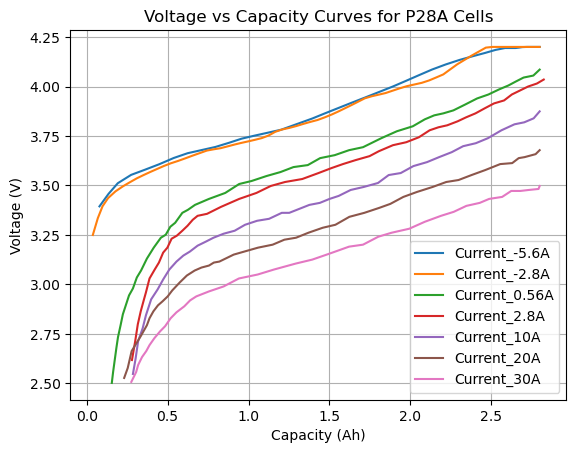

In [3]:
import matplotlib.pyplot as plt

for label in list(SoC_dict.keys()):
    plt.plot(SoC_dict[label][:,0], SoC_dict[label][:,1], label=label)

plt.legend()
plt.grid()
plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.title("Voltage vs Capacity Curves for P28A Cells")
plt.savefig("Voltage_Capacity_Curves_For_P28A.png")
plt.show()